# 311 Service Request Data Exploration and Analysis

<a id='table_of_contents'></a>
## Table of Contents:

1. [Findings from Exploratory Analysis](#Findings)<br>
2. [Importing packages and establishing connection with Chicago Data Portal](#Import)<br>
3. [CDP Data Pull using Scorata API](#SamplePull)<br>
4. [Exploratory Data Analysis](#EDA)<br>
    4.1 [Analyzing types of service requests and their location](#SRType_Loc)<br>
    4.2 [Analyzing `community_area` and `street_address` for missing values](#MissingVal)<br>
6. [Creating dataset for Analyzing 311 Service Requests from 2019-2021](#ActualDataPull)<br>
    6.1 [API Data Pull from Chicago City Data Portal](#APIPull)<br>
    6.2 [Creating metrics to measure service responsiveness](#CreateMetrics)
7. [Bringing in census data](#Census)<br>
8. [Analysis of Unresolved Requests](#Unresolved)<br>
9. [Observing Correlation between service responsiveness and demographics](#Correlation)<br>
10. [Some Insights from the 311 Dashboard](#Insights)<br>
    10.1 [Comparing number of service request based on neighborhood income level](#SR_Income)<br>
    10.2 [Deep-dive into Hyde Park's service request resolution time](#HP_Deepdive)

<a id='Findings'></a>
## Findings from Exploratory Analysis (Assumptions / Things to Note)

- We are not considering two specific service request types (sr_type) in our data:
    1. 311 Informational Calls: this is a 311 Call Center. These requests are informational not relevant to our analysis.
    2. aircraft noise complaint: this maps to the Aviation Administration building, and exclusively deals with aircraft noise complaints. This is either geo-tagged to a single building and doesn't provide required variation across neighborhoods or are all completed within 10s - which points to an automated log. 
<br><br>    
- We have removed rows where service resolution time <= 0. These are mainly due to data anomalies.
<br><br>
- Resolution times have been bucketed in such a way that:
    1. Each time-period bucket has similar number of complaints
    2. They make more logical/real-world sense for analysis (For eg: service resolution within 1 hour is very different from service resolution in 12 hours)
<br><br>
- From amongst the unresolved service requests, below are the ones that have highest percentage of unresolved each year:
    - Tree Planting Request
    - Sidewalk Inspection Request
    - Lead Inspection Request
<br><br>
- From our dashboard, we can observe that...
    - in neighborhoods with a higher percentage of the population making minimal income, there are more service requests made. We see the opposite trend for high-earning neighborhoods.
    - compared to Chicago as a whole, Hyde Park's median request resolution time is now on par, as opposed to the lag in 2019.
<br>

[Back to Table of Contents](#table_of_contents)

<a id='Import'></a>
## Importing packages and establishing connection with Chicago Data Portal

In [1]:
import pandas as pd
from sodapy import Socrata
import numpy as np
import datetime
from datetime import date
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# pd.set_option('display.max_rows', 1000)
# pd.options.display.max_columns = None

In [2]:
socrata_domain = "data.cityofchicago.org"
socrata_dataset_identifier = "v6vf-nfxy"
app_token = "6tRoBirkYQMdr8MMFR8FzgBXq"
api_username = "v4vigtory@gmail.com"
api_password = "311_TeamVeam"

In [3]:
client = Socrata(socrata_domain, app_token, username=api_username, password=api_password)

[Back to Table of Contents](#table_of_contents)

<a id='SamplePull'></a>
## CDP Data Pull using Scorata API

For our initial analysis, we will look only at the 2021 Service Request Data.

In [4]:
sr_2021_sample = client.get(socrata_dataset_identifier,
                     select = '''sr_number, sr_type, sr_short_code, 
                                 owner_department, status, 
                                 created_date, closed_date, date_extract_y(created_date) as year, 
                                 street_address, city, state, zip_code, community_area, location''',
                     where = "date_extract_y(created_date) = 2021", 
                     limit = 10000000)
sr_2021_sample_df = pd.DataFrame(sr_2021_sample)

In [5]:
sr_2021_sample_df.shape

(1743647, 14)

[Back to Table of Contents](#table_of_contents)

<a id='EDA'></a>
## Exploratory Data Analysis

<a id='SRType_Loc'></a>
### Analyzing types of service requests and their location

#### Unique street_address and counts corresponding to them

In [6]:
sr_2021_sample_df.street_address.value_counts()

2111 W Lexington ST      655546
10510 W ZEMKE RD         316891
10000 W OHARE AIRPORT       313
1458 N WESTERN AVE          234
2601 N MILWAUKEE AVE        202
                          ...  
8554 S WOODLAWN AVE           1
5709 N WESTERN AVE            1
2111 W 67TH PL                1
7710 W BERWYN AVE             1
1969 S TRUMBULL AVE           1
Name: street_address, Length: 361742, dtype: int64

As we can see, a **very high number of service requests are coming from 2 specific locations** in Chicago:
1. 2111 W Lexington ST
2. 10510 W ZEMKE RD

#### Understanding what locations the street_address with high service request numbers point to:

In [7]:
#Importing the Nominatim geocoder class 
from geopy.geocoders import Nominatim

#making an instance of Nominatim class
geolocator = Nominatim(user_agent="my_request")

In [8]:
#address we need to geocode
loc1 = "10510 W ZEMKE RD, Chicago, Illinois, 60666"
loc2 = "2111 W Lexington ST, Chicago, Illinois, 60612"

In [9]:
#applying geocode method to get the location
location = geolocator.geocode(loc1)
print(location.address)
print((location.latitude, location.longitude))

Aviation Administration Building (DOA/OMP), 10510, West Zemke Road, O'Hare, Chicago, Jefferson Township, Cook County, Illinois, 60666, United States
(41.9949158, -87.88773078235056)


In [10]:
#applying geocode method to get the location
location = geolocator.geocode(loc2)
print(location.address)
print((location.latitude, location.longitude))

311 Call Center, 2111, West Lexington Street, Illinois Medical District, Near West Side, Chicago, Cook County, Illinois, 60612, United States
(41.8719137, -87.67985041445382)


We see that both these locations are **specific buildings** in Chicago:
1. 311 Call Center
2. Aviation Administration Building

These **will not provide us the required variation in terms of spread of service requests across Community Areas**. Given their high numbers, they will skew our results.

Before removing these locations from our analysis, we will take a look at whether these locations also correspond to specific Service Request types.

#### Unqiue values of `sr_type` and counts corresponding to them:

In [17]:
sr_2021_sample_df.sr_type.value_counts()

311 INFORMATION ONLY CALL                           656348
Aircraft Noise Complaint                            317127
Graffiti Removal Request                             93720
Rodent Baiting/Rat Complaint                         65897
Garbage Cart Maintenance                             54919
                                                     ...  
Renters and Foreclosure Complaint                       31
Smokeless Tobacco at Sports Event Complaint              9
Licensed Pharmaceutical Representative Complaint         5
Inaccurate Retail Scales Complaint                       5
Petcoke Dust Complaint                                   1
Name: sr_type, Length: 94, dtype: int64

We see that as expected from the location and the buildings, these correspond either to:
1. 311 Information only calls
2. Aviation Noise complaints - almost all specific to the Aviation Administration building.

These are also not useful for our analysis.

#### Deciding whether to filter based on `location` or `sr_type`:

In [18]:
sr_2021_sample_df['diff_mins'] = (
    pd.to_datetime(sr_2021_sample_df['closed_date']) - 
    pd.to_datetime(sr_2021_sample_df['created_date']))/np.timedelta64(1,'m')

In [19]:
sr_2021_sample_df[sr_2021_sample_df.sr_type.isin(
    ['311 INFORMATION ONLY CALL', 'Aircraft Noise Complaint'])].groupby(by = 'sr_type').diff_mins.value_counts()

sr_type                    diff_mins
311 INFORMATION ONLY CALL  0.000000     491083
                           0.016667     164969
                           0.033333        242
                           0.050000         36
                           0.066667          8
                           0.083333          6
                           0.100000          3
                           0.116667          1
Aircraft Noise Complaint   0.000000     237602
                           0.016667      79367
                           0.033333        118
                           0.050000         29
                           0.066667          7
                           0.083333          2
                           0.116667          1
                           0.183333          1
Name: diff_mins, dtype: int64

We see that all of these service requests are resolved within 10 seconds, and are hence mostly automated logs, rather than actual requests that are resolved.

We can thus **remove the `sr_type` '311 INFORMATION ONLY CALL' and 'Aircraft Noise Complaint'** from our analysis dataset

[Back to Table of Contents](#table_of_contents)

<a id='MissingVal'></a>
### Analyzing `community_area` and `street_address` for missing values

In [20]:
sr_2021_sample_df.community_area.isna().sum()

2462

In [21]:
sr_2021_sample_df["street_address"].isna().sum()

1981

In [22]:
sr_2021_sample_df[(
    sr_2021_sample_df.community_area.isna() == False) & (sr_2021_sample_df.street_address.isna() == True)]

,sr_number,sr_type,sr_short_code,owner_department,status,created_date,closed_date,year,street_address,city,state,zip_code,community_area,location,diff_mins
50145,SR21-01454545,Building Violation,BBA,DOB - Buildings,Completed,2021-08-16T14:01:58.000,2021-08-17T13:48:33.000,2021,NaN,NaN,NaN,60618,5,"{'latitude': '41.93850953219724', 'longitude':...",1426.583333
153215,SR21-01522661,Report an Injured Animal,EAQ,Animal Care and Control,Completed,2021-08-26T15:18:06.000,2021-08-26T19:31:07.000,2021,NaN,NaN,NaN,60624,29,"{'latitude': '41.86597958110466', 'longitude':...",253.016667
219523,SR21-01566906,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,2021-09-02T12:21:05.000,2021-09-02T13:15:02.000,2021,NaN,NaN,NaN,60647,23,"{'latitude': '41.9136376036085', 'longitude': ...",53.950000
482188,SR21-01909910,Street Light Out Complaint,SFD,CDOT - Department of Transportation,Completed,2021-10-28T19:06:50.000,2021-11-11T06:18:54.000,2021,NaN,NaN,NaN,NaN,35,"{'latitude': '41.833663597651004', 'longitude'...",19392.066667
482324,SR21-01909975,Street Light Out Complaint,SFD,CDOT - Department of Transportation,Completed,2021-10-28T19:28:19.000,2021-11-16T16:51:10.000,2021,NaN,NaN,NaN,NaN,25,"{'latitude': '41.894959407435735', 'longitude'...",27202.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846406,SR21-00219009,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,2021-02-08T11:53:37.000,2021-02-08T11:53:43.000,2021,NaN,NaN,NaN,NaN,24,"{'latitude': '41.9008342588991', 'longitude': ...",0.100000
891464,SR21-00277102,Missed Garbage Pick-Up Complaint,SCC,Streets and Sanitation,Completed,2021-02-18T14:28:37.000,2021-02-20T09:01:41.000,2021,NaN,NaN,NaN,60636,67,"{'latitude': '41.76114649420335', 'longitude':...",2553.066667
1079739,SR21-00519288,Abandoned Vehicle Complaint,SKA,Streets and Sanitation,Canceled,2021-03-30T12:11:31.000,2022-01-24T10:50:31.000,2021,NaN,NaN,NaN,60660,2,"{'latitude': '41.994270573437426', 'longitude'...",431919.000000
1089169,SR21-00531887,Street Light Out Complaint,SFD,CDOT - Department of Transportation,Completed,2021-04-01T11:38:16.000,2021-04-02T11:58:55.000,2021,NaN,NaN,NaN,60660,2,"{'latitude': '41.994270573437426', 'longitude'...",1460.650000


We will retain these rows above, since we have their corresponding `community_area` number that will help us map them.

In [23]:
sr_2021_sample_df[(
    sr_2021_sample_df.community_area.isna() == True) & (sr_2021_sample_df.street_address.isna() == False)]

,sr_number,sr_type,sr_short_code,owner_department,status,created_date,closed_date,year,street_address,city,state,zip_code,community_area,location,diff_mins
57,SR21-00328378,Fly Dumping Complaint,SDR,Streets and Sanitation,Completed,2021-02-26T19:13:29.000,2021-03-02T08:07:56.000,2021,"4100–4198 N Cumberland Ave, River Grove, IL 6...",NaN,NaN,NaN,NaN,NaN,5094.450000
109,SR21-00654689,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,2021-04-21T13:53:38.000,2021-04-22T13:53:54.000,2021,4910 s honore ave Chicago ok 60609,NaN,NaN,NaN,NaN,NaN,1440.266667
152,SR21-00637717,Tree Trim Request,SEF,Streets and Sanitation,Open,2021-04-19T09:35:57.000,NaN,2021,4648 N VIRGINIA AVE,NaN,NaN,NaN,NaN,NaN,NaN
160,SR21-00493686,Water On Street Complaint,AAE,DWM - Department of Water Management,Completed,2021-03-25T18:13:15.000,2021-04-12T12:03:17.000,2021,Damen south if Schiller west side of street,NaN,NaN,NaN,NaN,NaN,25550.033333
194,SR21-00495154,Rodent Baiting/Rat Complaint,SGA,Streets and Sanitation,Completed,2021-03-26T07:37:27.000,2021-03-31T07:03:57.000,2021,5541 W. Newport Chicago IL,NaN,NaN,NaN,NaN,NaN,7166.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732090,SR21-01406661,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2021-08-09T14:59:17.000,2021-08-09T14:59:17.000,2021,2111 W Lexington ST,Chicago,Illinois,60612,NaN,"{'latitude': '41.962141282682566', 'longitude'...",0.000000
1735744,SR21-01412022,Street Light On During Day Complaint,SFN,CDOT - Department of Transportation,Open,2021-08-10T11:42:23.000,NaN,2021,7171 W NORTH AVE,NaN,NaN,NaN,NaN,"{'latitude': '41.90884646310495', 'longitude':...",NaN
1736958,SR21-01413956,Street Light Pole Door Missing Complaint,SFQ,CDOT - Department of Transportation,Open,2021-08-10T14:45:44.000,NaN,2021,7900 S CICERO AVE,NaN,NaN,0,NaN,"{'latitude': '41.749063281333775', 'longitude'...",NaN
1740771,SR21-01419862,Traffic Signal Out Complaint,SFB,CDOT - Department of Transportation,Completed,2021-08-11T10:00:36.000,2021-08-11T10:07:21.000,2021,11900 S ASHLAND AVE,NaN,NaN,60643,NaN,"{'latitude': '41.677466386334025', 'longitude'...",6.750000


In [24]:
sr_2021_sample_df[sr_2021_sample_df.street_address.isna() == False].community_area.isna().sum()

1027

We will drop these rows from our analysis, since we are unable to map them to a location and they form a very small percentage of all data.

[Back to Table of Contents](#table_of_contents)

<a id='ActualDataPull'></a>
## Creating dataset for Analyzing 311 Service Requests from 2019-2021

<a id='APIPull'></a>
### API Data Pull from Chicago City Data Portal

In [25]:
sr_2021 = client.get(socrata_dataset_identifier,
                     select = '''sr_number, sr_type, sr_short_code, 
                                 owner_department, status,
                                 created_date, closed_date, date_extract_y(created_date) as year,
                                 street_address, city, state, zip_code, community_area, location''',
                     where = '''date_extract_y(created_date) = 2021 AND 
                                 community_area IS NOT NULL 
                                 AND sr_type NOT IN ('311 INFORMATION ONLY CALL', 'Aircraft Noise Complaint')''', 
                     limit = 10000000)
sr_2021_df = pd.DataFrame(sr_2021)

In [26]:
sr_2020 = client.get(socrata_dataset_identifier,
                     select = '''sr_number, sr_type, sr_short_code, 
                                 owner_department, status,
                                 created_date, closed_date, date_extract_y(created_date) as year,
                                 street_address, city, state, zip_code, community_area, location''',
                     where = '''date_extract_y(created_date) = 2020 AND 
                                 community_area IS NOT NULL AND 
                                 sr_type NOT IN ('311 INFORMATION ONLY CALL', 'Aircraft Noise Complaint')''', 
                     limit = 10000000)
sr_2020_df = pd.DataFrame(sr_2020)

In [27]:
sr_2019 = client.get(socrata_dataset_identifier,
                     select = '''sr_number, sr_type, sr_short_code,
                                 owner_department, status,
                                 created_date, closed_date, date_extract_y(created_date) as year,
                                 street_address, city, state, zip_code, community_area, location''',
                     where = '''date_extract_y(created_date) = 2019 AND 
                                 community_area IS NOT NULL AND 
                                 sr_type NOT IN ('311 INFORMATION ONLY CALL', 'Aircraft Noise Complaint')''', 
                     limit = 10000000)
sr_2019_df = pd.DataFrame(sr_2019)

In [28]:
sr_2019_21_df = pd.concat([sr_2021_df,sr_2020_df,sr_2019_df])

In [29]:
sr_2019_21_df.shape

(2415606, 14)

[Back to Table of Contents](#table_of_contents)

<a id='CreateMetrics'></a>
### Creating metrics to measure service responsiveness

In [30]:
df = sr_2019_21_df.copy()

In [31]:
# resol_time
df['diff_mins'] = (pd.to_datetime(df['closed_date']) - pd.to_datetime(df['created_date']))/np.timedelta64(1,'m')

# time_open_not_resolved
df['time_open_unresolved'] = np.where((df['diff_mins'].isna()),1, 0)

#### Sanity check to ensure the resolution time is positive:

In [32]:
df[(df.diff_mins <= 0)]

,sr_number,sr_type,sr_short_code,owner_department,status,created_date,closed_date,year,street_address,zip_code,community_area,location,city,state,diff_mins,time_open_unresolved
0,SR21-00947241,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,2021-06-04T10:31:54.000,2021-06-04T10:31:54.000,2021,2707 N MILWAUKEE AVE,60647,22,"{'latitude': '41.93039087', 'longitude': '-87....",NaN,NaN,0.0,0
589,SR21-01710541,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2021-09-25T15:07:58.000,2021-09-25T15:07:58.000,2021,1954 N HALSTED ST,60614,7,"{'latitude': '41.917578620244576', 'longitude'...",NaN,NaN,0.0,0
931,SR21-01426096,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2021-08-11T19:54:36.000,2021-08-11T19:54:36.000,2021,77 E WASHINGTON ST,60602,32,"{'latitude': '41.88320542906238', 'longitude':...",NaN,NaN,0.0,0
945,SR21-01426143,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2021-08-11T20:02:52.000,2021-08-11T20:02:52.000,2021,847 N MILWAUKEE AVE,60642,24,"{'latitude': '41.89731790456385', 'longitude':...",NaN,NaN,0.0,0
999,SR21-01426173,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2021-08-11T20:04:35.000,2021-08-11T20:04:35.000,2021,2226 N ELSTON AVE,60614,22,"{'latitude': '41.92196553174694', 'longitude':...",NaN,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808857,SR19-03203256,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2019-12-26T12:32:25.000,2019-12-26T12:32:25.000,2019,3880 N MILWAUKEE AVE,60641,15,"{'latitude': '41.95160529679968', 'longitude':...",NaN,NaN,0.0,0
809330,SR19-03206243,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2019-12-26T15:39:37.000,2019-12-26T15:39:37.000,2019,1564 N DAMEN AVE,60622,24,"{'latitude': '41.91014546422996', 'longitude':...",NaN,NaN,0.0,0
814841,SR19-03227447,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2019-12-30T13:35:41.000,2019-12-30T13:35:41.000,2019,15 W ILLINOIS ST,60654,8,"{'latitude': '41.89074650503313', 'longitude':...",NaN,NaN,0.0,0
814931,SR19-03227675,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2019-12-30T14:02:09.000,2019-12-30T14:02:09.000,2019,437 W HARRISON ST,60607,28,"{'latitude': '41.874390487627245', 'longitude'...",NaN,NaN,0.0,0


In [33]:
len(df[(df.diff_mins <= 0)])/(len(df))*100

0.15627548532335156

In [34]:
df[(df.diff_mins <= 0)].sr_type.value_counts()

Vehicle Parked in Bike Lane Complaint    3286
E-Scooter                                 455
Extreme Weather Notification               25
Open Fire Hydrant Complaint                 3
No Water Complaint                          2
Graffiti Removal Request                    1
Vicious Animal Complaint                    1
Report an Injured Animal                    1
Traffic Signal Out Complaint                1
Name: sr_type, dtype: int64

There are 3775 rows for which the resolution time is either 0 or negative. This is a negligible number (~0.15%), and we will remove these data anomalies from the analysis

#### Creating a dataset with service requests having resolution time > 0:

In [35]:
df = df[(df.diff_mins > 0) | (df.time_open_unresolved == 1)]

#### Separating out unresolved service requests for a separate analysis

In [36]:
len(df[df.time_open_unresolved == 1])

78003

In [37]:
len(df[df.time_open_unresolved == 1])/len(df)*100

3.2341818311482022

3.23% of the total issues remain unresolved. We will separate them out for later analysis.

In [45]:
df_unresol = df[df.time_open_unresolved == 1]
df_resol = df[df.time_open_unresolved == 0]

#### Creating flag columns to bucket service complaint resolution times:

In [46]:
# time_open_less_than_1_min
df_resol['time_open_less_than_1_min'] = np.where(df_resol['diff_mins'] < 1, 1,
                                                 0)

# time_open_1_min_1_hr
df_resol['time_open_1_min_1_hr'] = np.where(
    (df_resol['diff_mins'] >= 1) & (df_resol['diff_mins'] < 60), 1, 0)

# time_open_1_hr_12_hr
df_resol['time_open_1_hr_12_hr'] = np.where(
    (df_resol['diff_mins'] >= 60) & (df_resol['diff_mins'] < 60 * 12), 1, 0)

# time_open_12_24_hr
df_resol['time_open_12_24_hr'] = np.where(
    (df_resol['diff_mins'] >= 60 * 12) & (df_resol['diff_mins'] < 60 * 24), 1,
    0)

# time_open_1_3_day
df_resol['time_open_1_3_day'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 1) &
    (df_resol['diff_mins'] < 60 * 24 * 3), 1, 0)

# time_open_3_7_day
df_resol['time_open_3_7_day'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 3) &
    (df_resol['diff_mins'] < 60 * 24 * 7), 1, 0)

# time_open_7_14_day
df_resol['time_open_7_14_day'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 7) &
    (df_resol['diff_mins'] < 60 * 24 * 14), 1, 0)

# time_open_14_30_day
df_resol['time_open_14_30_day'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 14) &
    (df_resol['diff_mins'] < 60 * 24 * 30), 1, 0)

# time_open_1_3_month
df_resol['time_open_1_3_month'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 30 * 1) &
    (df_resol['diff_mins'] < 60 * 24 * 30 * 3), 1, 0)

# time_open_3_12_month
df_resol['time_open_3_12_month'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 30 * 3) &
    (df_resol['diff_mins'] < 60 * 24 * 30 * 12), 1, 0)

# time_open_1_year_plus
df_resol['time_open_1_year_plus'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 30 * 12), 1, 0)

#### Comparing number of service requests under each time-period bucket

In [47]:
df_time_bucket_perc = df_resol[['time_open_less_than_1_min', 'time_open_1_min_1_hr', 'time_open_1_hr_12_hr', 'time_open_12_24_hr',
    'time_open_1_3_day', 'time_open_3_7_day', 'time_open_7_14_day','time_open_14_30_day', 'time_open_1_3_month', 
    'time_open_3_12_month','time_open_1_year_plus']].aggregate(np.mean, axis = 0).reset_index()

df_time_bucket_perc = df_time_bucket_perc.rename(columns = {'index':'time_bucket', 0:'perc_sr'})
df_time_bucket_perc['perc_sr'] = df_time_bucket_perc['perc_sr']*100
df_time_bucket_perc

,time_bucket,perc_sr
0,time_open_less_than_1_min,11.002525
1,time_open_1_min_1_hr,6.502664
2,time_open_1_hr_12_hr,6.913106
3,time_open_12_24_hr,8.062462
4,time_open_1_3_day,13.133187
5,time_open_3_7_day,11.086250
6,time_open_7_14_day,9.354631
7,time_open_14_30_day,10.706102
8,time_open_1_3_month,12.780333
9,time_open_3_12_month,8.865906


[Back to Table of Contents](#table_of_contents)

<a id='Census'></a>
## Bringing in census data

In [41]:
census_pop_data = pd.read_csv("../data/census_demos_pop.csv", index_col = 0)
census_demo_data = pd.read_csv("../data/census_demos.csv", index_col = 0)

In [42]:
census_demo_data

,cca_name,cca_num,percent_unemployed,LTM_income_sub_10k,LTM_income_10-15k,LTM_income_15_20k,LTM_income_20_25k,LTM_income_25_30k,LTM_income_30_35k,LTM_income_35_40k,...,1.50_1.85_poverty_line,1.85_2.00_poverty_line,2.00+_poverty_line,White,Black_or_African_American,American_Indian_or_Alaska_Native,Asian,Native_Hawaiian_or_Other_Pacific_Islander,some_other_race_alone,two_or_more_races
0,Rogers Park,1,9.765415,12.997481,7.031906,7.716205,7.594458,6.498741,5.377834,6.259446,...,6.588648,3.604447,49.664521,59.486784,25.287673,0.231609,6.475865,0.000000,4.635859,3.882210
1,West Ridge,2,8.842689,9.436204,4.039990,7.563714,6.125543,4.818487,5.502745,5.797755,...,6.351617,4.078762,53.420534,57.607567,11.600726,0.301893,23.514423,0.000000,3.542397,3.432995
2,Uptown,3,9.804309,15.620403,6.688105,6.072320,5.524956,4.686805,4.132599,2.894188,...,6.309524,1.272321,59.207589,62.818071,21.158206,0.275677,8.761811,0.083429,3.213813,3.688993
3,Lincoln Square,4,7.199730,6.996110,3.900729,4.525284,4.152742,4.426670,3.467923,4.519805,...,5.037708,1.792070,73.158772,76.428449,3.741321,0.284586,11.116018,0.000000,5.012144,3.417482
4,North Center,5,4.236298,3.554975,1.499003,2.289761,2.832978,2.097229,3.273052,2.860483,...,3.778061,0.465749,85.527077,87.863559,2.024666,0.147301,4.369928,0.000000,1.946683,3.647864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Washington Heights,73,19.685816,7.336070,5.788864,6.809809,7.399221,6.262499,7.451847,5.283654,...,9.198359,4.228188,60.037286,1.703791,96.031863,0.781826,0.000000,0.000000,0.468358,1.014161
73,Mount Greenwood,74,7.101342,4.227970,1.889422,2.834133,2.632802,2.586340,2.307573,3.376181,...,3.725166,1.655629,86.766004,91.939520,3.535112,0.202311,2.039078,0.000000,0.899750,1.384230
74,Morgan Park,75,12.097006,6.104456,5.424054,4.666986,5.864878,5.903210,5.107810,5.270724,...,5.478255,1.562719,66.022235,38.776492,54.583863,0.113351,0.309140,0.000000,3.084533,3.132621
75,Ohare,76,8.419757,7.027675,6.733493,6.286773,8.444105,4.968403,4.521682,3.127043,...,3.703026,2.450398,64.780104,80.208948,0.899387,0.000000,9.370883,0.045424,6.354758,3.120600


[Back to Table of Contents](#table_of_contents)

<a id='Unresolved'></a>
## Analysis of Unresolved Requests

In [48]:
# create column 'time_open'
df_unresol['time_open'] = ((pd.to_datetime("today")) - pd.to_datetime(df_unresol['created_date']))/np.timedelta64(1,'m')

In [49]:
df_unresol['community_area'] = df_unresol['community_area'].astype(int)
df['community_area'] = df['community_area'].astype(int)

#### Unresolved issues by year

In [50]:
df_unresol.year.value_counts()

2021    53355
2020    17723
2019     6925
Name: year, dtype: int64

Understandably, there are more unresolved issues in 2021 than in 2020, which is greater than ones in 2019. The older requests simply have more time to allow the requests to close.

#### Unresolved service requests across community :

In [51]:
df_unresol_by_cca = df_unresol.groupby(['year','community_area']).agg(tot_unresol = ('sr_number', len))
df_totreq_by_cca = df.groupby(['year','community_area']).agg(tot_req = ('sr_number', len))

df_unresol_perc_cca = pd.merge(df_unresol_by_cca, 
                   df_totreq_by_cca, 
                   left_on = ['year','community_area'],
                   right_on = ['year','community_area'],
                   how='left')

df_unresol_perc_cca['perc_unresol'] = (df_unresol_perc_cca['tot_unresol']/df_unresol_perc_cca['tot_req'])*100
df_unresol_perc_cca.sort_values(['year','perc_unresol'], ascending = [True, False])

tot_unresol  tot_req  perc_unresol
year community_area                                    
2019 9                        91     3576      2.544743
     16                      312    18245      1.710058
     12                      124     7626      1.626016
     32                      137     8456      1.620151
     8                       204    12605      1.618405
...                          ...      ...           ...
2021 57                      236     5977      3.948469
     29                      589    15982      3.685396
     64                      289     7843      3.684814
     26                      286     7828      3.653551
     37                       60     1956      3.067485

[231 rows x 3 columns]

#### Unresolved service requests across `sr_types` and `owner_departnment`

In [52]:
df_totreq_sr_type = df.groupby(['year','sr_type']).agg(tot_req = ('sr_number', len))
df_totunresol_sr_type = df_unresol.groupby(['year','sr_type']).agg(tot_unresol = ('sr_number', len))
df_unresol_perc_sr_type = pd.merge(df_totunresol_sr_type, 
                   df_totreq_sr_type, 
                   left_on = ['year','sr_type'],
                   right_on = ['year','sr_type'],
                   how='left')
df_unresol_perc_sr_type['perc_unresol'] = (df_unresol_perc_sr_type['tot_unresol']/df_unresol_perc_sr_type['tot_req'])*100
df_unresol_perc_sr_type[(df_unresol_perc_sr_type.perc_unresol > 30) & (df_unresol_perc_sr_type.tot_req > 100)].sort_values(['year','perc_unresol'], ascending = [True, False])

tot_unresol  tot_req  \
year sr_type                                                           
2019 Commercial Fire Safety Inspection Request          359      359   
     Tree Planting Request                             2877     5895   
     Pushcart Food Vendor Complaint                      86      195   
     Lead Inspection Request                            120      341   
2020 Tree Planting Request                             3070     5111   
     Sidewalk Inspection Request                       3569     6237   
     Lead Inspection Request                             94      253   
     Bicycle Request/Complaint                          129      402   
2021 Sidewalk Inspection Request                       7571     7873   
     Street Light Pole Door Missing Complaint           591      745   
     Tree Trim Request                                25749    32947   
     Tree Planting Request                             4302     5689   
     Bicycle Request/Complaint                          335      499   
     Street Light On During Day Complaint               558     1121   
     Wage Complaint                                      84      184   

                                                perc_unresol  
year sr_type                                                  
2019 Commercial Fire Safety Inspection Request    100.000000  
     Tree Planting Request                         48.804071  
     Pushcart Food Vendor Complaint                44.102564  
     Lead Inspection Request                       35.190616  
2020 Tree Planting Request                         60.066523  
     Sidewalk Inspection Request                   57.223024  
     Lead Inspection Request                       37.154150  
     Bicycle Request/Complaint                     32.089552  
2021 Sidewalk Inspection Request                   96.164105  
     Street Light Pole Door Missing Complaint      79.328859  
     Tree Trim Request                             78.152791  
     Tree Planting Request                         75.619617  
     Bicycle Request/Complaint                     67.134269  
     Street Light On During Day Complaint          49.776985  
     Wage Complaint                                45.652174

Tree Planting Request, Sidewalk Inspection Request, and Lead Inspection Request quite consistently have high percentage of unresolved issues. We think Commerical Fire Safety Inspection Request might be a data anomaly, as 100% of its requests are unresolved and it only shows up for 2019.

[Back to Table of Contents](#table_of_contents)

<a id='Correlation'></a>
## Observing Correlation between service responsiveness and demographics

In [53]:
df_corr_grid = pd.read_csv("../data/sr_census_df.csv", index_col = 0)
df_corr_grid_filtered = df_corr_grid[['community_area','total_reqs', 'avg_resol_time', 
                                      'median_resol_time','perc_resol_unresolved',
                                      'total_num_race_estimates', 'percent_unemployed', 'White', 
                                      'Black_or_African_American', 'American_Indian_or_Alaska_Native', 
                                      'Asian', 'Native_Hawaiian_or_Other_Pacific_Islander']]
corr = df_corr_grid_filtered.corr()

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

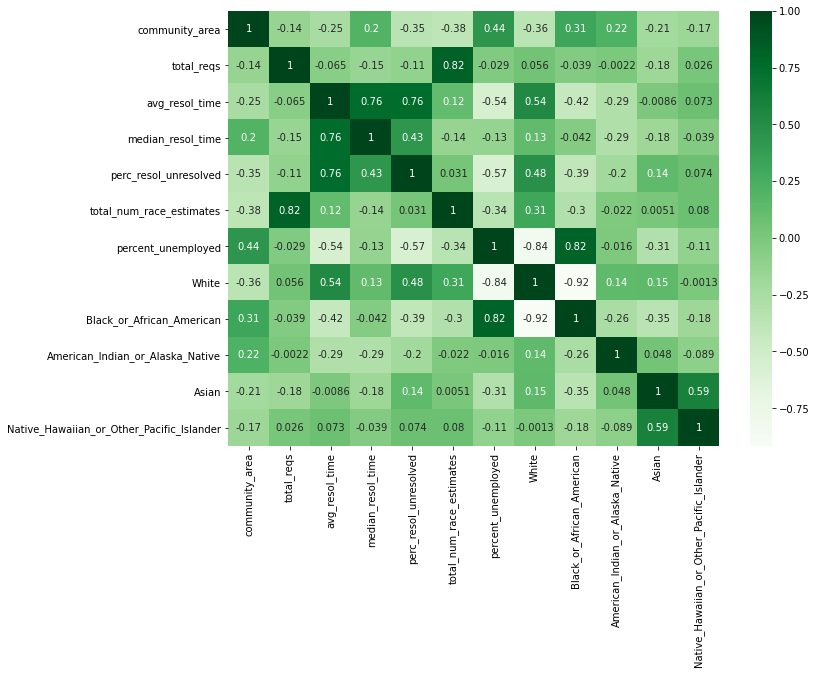

In [55]:
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

The initial overview of the median resolution time shows higher median resolution time for South Side (appox 3.5 days) and Far South East Side (appox 6.7 days) compared to the North Side (appox 2.8 days) and Central Chicago (appox 2.5 days). However, we do not want to jump to conclusions purely based on these top-level numbers. As resolution times are wildly different for different types of service requests, a great next step would be to compare the median resolution times for different service request types for these neighborhoods. 

The above high-level correlation map does not reveal any particularly interest insights, but that could be because: 
1. looking at the entire correlation map for all service request types may be masking underlying differences within service types. 

2. average resolution times are potentially skewing the overall numbers, as the many resolutions that close quickly are not weighted as heavily as they should be. 

[Back to Table of Contents](#table_of_contents)

<a id='Insights'></a>
## Some Insights from the 311 Dashboard

<a id='SR_Income'></a>
### Comparing number of service request based on neighborhood income level 

![Service request per 1000 vs Income range](images/scatter.png)

From the above comparison, we are able to see the average annual service requests/1000 people in the 77 community areas. The left graph's x-axis is the % of the population making up to \\$50k of annual income, and the right graph's x-axis is the percentage of the population making \\$125k-\\$200k of annual income. **We can see that in neighborhoods with a higher percentage of the population making minimal income, there are more service requests made. We see the opposite trend for high-earning neighborhoods.** 

This may be due to two factors: 
1. High earners may rely less on public infrastructure, and 
2. Better neighborhoods may just have better public infrastructure that proactively deals with issues without having to be addressed by its residents.

<a id='HP_Deepdive'></a>
### Deep-dive into Hyde Park's service request resolution time

!["Hyde Park's service request resolution time"](images/bar_chart.png)

From the above visualization, we are able to observe two important things. 
1. In Hyde Park, 2020 seemed to witness a peak in the % of service requests resolved in less than 1 hour, whereas most of 2019's service requests were resolved in 1-3 months. One hypothesis is that this may be an impact of the pandemic, where actually working on a lot of these requests were unfeasible and hence marked "resolved" very quickly. Further deep dive into service request types may enhance our understanding of these results. 

2. Compared to Chicago as a whole, Hyde Park's median request resolution time is now on par, as opposed to the lag in 2019. 

[Back to Table of Contents](#table_of_contents)